# 16 Land cover statistics

## About the data

In this lesson we will use two datasets.

The first one is [GAP/LANDFIRE National Terrestrial Ecosystems data for 2011 @davidson_gaplandfire_2016](https://www.sciencebase.gov/catalog/item/573cc51be4b0dae0d5e4b0c5), from the [US Geological Survey (USGS)](https://www.usgs.gov). This is a categorical raster with a 30 m x 30 m pixel resolution representing highly thematically detailed land cover map of the U.S. We will access this data through the [Microsoft Planetary Computer (MPC) data catalog](https://planetarycomputer.microsoft.com/dataset/gap). The class names and corresponding codes have been saved to a separete CSV to simplify access in this lesson. Further information on how to access the classes directly from the data are available in the [MPC catalog](https://planetarycomputer.microsoft.com/dataset/gap#Example-Notebook).


The second dataset is a shapefile with the perimeters for 2017 California fires. This data was extracted from the CALFIRE's [Historical Wildland Fire Perimeters](https://gis.data.ca.gov/datasets/CALFIRE-Forestry::california-fire-perimeters-all/about).

## Import auxiliary geometries

Let's start by importing the necessary libraries:

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import geopandas as gpd
import rioxarray as rioxr
from shapely import box

import pystac_client
import planetary_computer

from IPython.display import Image 

Then import and select the Thomas Fire within the fire perimeters data:

<Axes: >

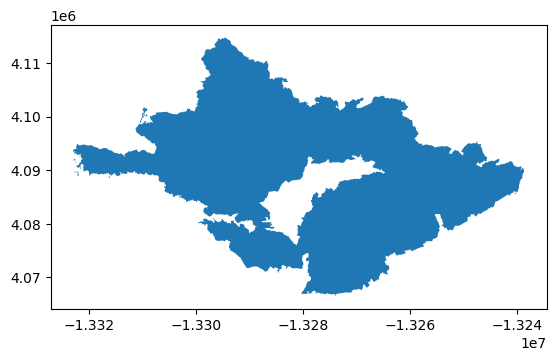

In [2]:
# UPDATE THIS AS NEEDED SO YOU CAN IMPORT THE DATA

fire_perimeters = gpd.read_file(os.path.join('data',
                  'California_Fire_Perimeters_2017',
                  'California_Fire_Perimeters_2017.shp'
                 ))
thomas_fire = fire_perimeters[fire_perimeters['FIRE_NAME']=='THOMAS']

# Examine fire perimeter data
thomas_fire.crs
thomas_fire.plot()

And import the CA state perimeter:

<Axes: >

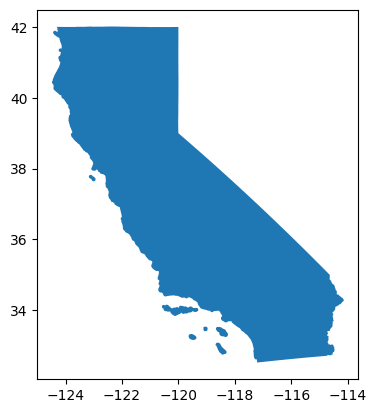

In [3]:
# UPDATE THIS AS NEEDED SO YOU CAN IMPORT THE DATA
ca = gpd.read_file(os.path.join('data',
                                'ca_state_boundary',   
                                'ca_state_boundary.shp'))
ca.plot()

And import the lables for the GAP Terrestrial Ecosystems Data:

In [4]:
labels = pd.read_csv(os.path.join('data',
                                  'GAP_National_Terrestrial_Ecosystems.csv')
                                  )
labels.head()

,class_label,code
0,0,0
1,South Florida Bayhead Swamp,1
2,South Florida Cypress Dome,2
3,South Florida Dwarf Cypress Savanna,3
4,South Florida Mangrove Swamp,4


## Catalog search

Our goal is to retrieve the National Terrestrial Ecosystems data over the fire perimeter. In the [last lesson](/book/chapters/lesson-16-STAC.qmd) we used GeoJSON-type dictionary to do the catalog search. Here we will use a list `[xmin, ymin, xmax, ymax]` with the coordinate values defining the four corners of the region we want to search data over. Just as the GeoJSON, these coordinates have to be in the EPSG:4326 CRS. 

Our bounding box will come from the Thomas Fire perimeter. Notice we use method chaining to reproject and extract the bounds.

In [5]:
# Create bounding box for search
thomas_fire_bbox = list(thomas_fire.to_crs('epsg:4326').total_bounds)
thomas_fire_bbox

[-119.68162520650904,
 34.27989979600195,
 -118.92518097019486,
 34.63745683414112]

Next, we connect to the Microsoft Planetary Computer data catalog and perform the search. The collection ID for the National Terrestrial Ecosystems data is `gap`:

In [6]:
# Open MPC data catalog
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# Search MPC catalog
search = catalog.search(collections = ['gap'],
                        bbox=thomas_fire_bbox)

search

# Retrieve search items
items = search.item_collection()
print(f'Returned {len(items)} items')
items

Returned 1 items


In [7]:
# Select unique search item
item = items[0]

# Display pre-rendered image
Image(url = item.assets['rendered_preview'].href, width = 600)


In [8]:
# Access raster data from item
lulc = rioxr.open_rasterio(item.assets['data'].href)
lulc

<xarray.DataArray (band: 1, y: 10000, x: 10000)> Size: 200MB
[100000000 values with dtype=uint16]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 80kB -2.361e+06 -2.361e+06 ... -2.061e+06
  * y            (y) float64 80kB 1.762e+06 1.762e+06 ... 1.462e+06 1.462e+06
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_SOFTWARE:        ERDAS IMAGINE
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    TIFFTAG_RESOLUTIONUNIT:  2 (pixels/inch)
    AREA_OR_POINT:           Area
    scale_factor:            1.0
    add_offset:              0.0

Notice that `band` is a dimension of length 1. We can "squeeze" the raster to simplify it:


In [9]:
# Remove length 1 dimensions
lulc = lulc.squeeze().drop_vars('band')
print("Size of dimensions: ", dict(lulc.sizes))

Size of dimensions:  {'y': 10000, 'x': 10000}


In [10]:
lulc.rio.bounds()

(-2361135.0, 1462215.0, -2061135.0, 1762215.0)

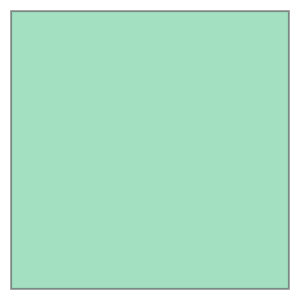

In [11]:
box(*lulc.rio.bounds())

In [12]:
# Create GeoDataFrame  from raster bounding box
lulc_bbox = gpd.GeoDataFrame(geometry = [box(*lulc.rio.bounds())],
                             crs = lulc.rio.crs)

lulc_bbox

,geometry
0,"POLYGON ((-2061135.000 1462215.000, -2061135.0..."


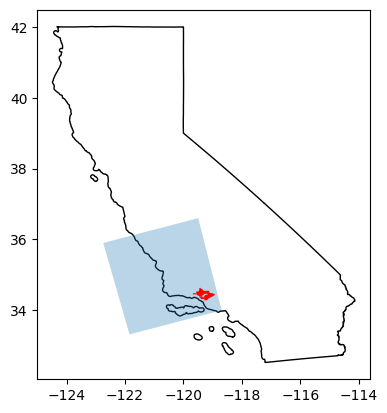

In [13]:
# Plot raster boundary, fire perimeter, and CA boundary
fig, ax = plt.subplots()
ca.plot(ax=ax, color = 'white', edgecolor='black')

# Reproject all other data to CA crs
lulc_bbox.to_crs(ca.crs).plot(ax = ax, alpha =0.3)
thomas_fire.to_crs(ca.crs).plot(ax=ax, color='red')

plt.show()



## Clip raster geometry

2-step clipping

1. Clip the raster using the fire perimeter bounding box using `rio.clip_box()`
2. Clip the simplified raster to the fire perimeter using `rio.clip()`

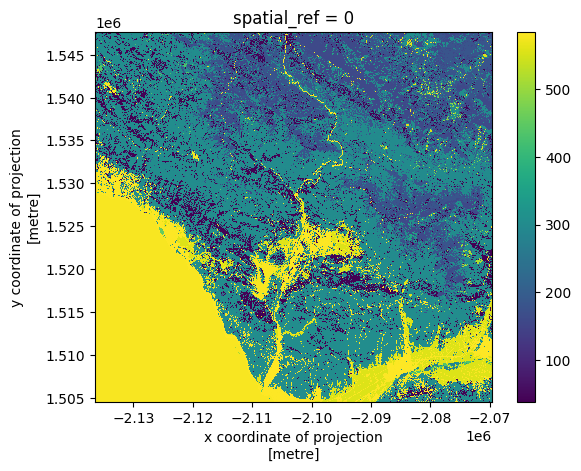

In [15]:
# Match CRSs and verify the update
thomas_fire_match = thomas_fire.to_crs(lulc.rio.crs)
assert thomas_fire_match.crs == lulc.rio.crs

# Clip large raster to detailed geometry in two steps 
lulc_step1 = lulc.rio.clip_box(*thomas_fire_match.total_bounds)
lulc_step1.plot()

In [ ]:
thomas_fire_match.total_bounds

/opt/anaconda3/envs/eds220-env/lib/python3.11/site-packages/xarray/core/duck_array_ops.py:215: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


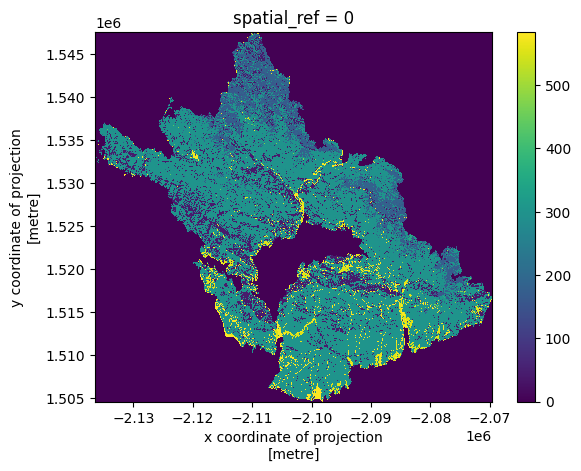

In [16]:
lulc_step2 = lulc_step1.rio.clip(thomas_fire_match.geometry)
lulc_step2.plot()

## Raster no-data values
`rio.clip()` function tries to replace values outside the fire perimeter with `np.nan` (a float!) but the raster's data type is `unit16`. The cast issue appears since `np.nan` cannot be caster as a `uunit16`.

To make sure the clipping function fills in any pixels with the adequate no-data value, let's manually set it 

In [20]:
print('Original no-data value: ', lulc.rio.nodata )

# Update raster's no-data value
lulc = lulc.rio.write_nodata(0)
print('Updated no-data value: ', lulc.rio.nodata)

Original no-data value:  None
Updated no-data value:  0


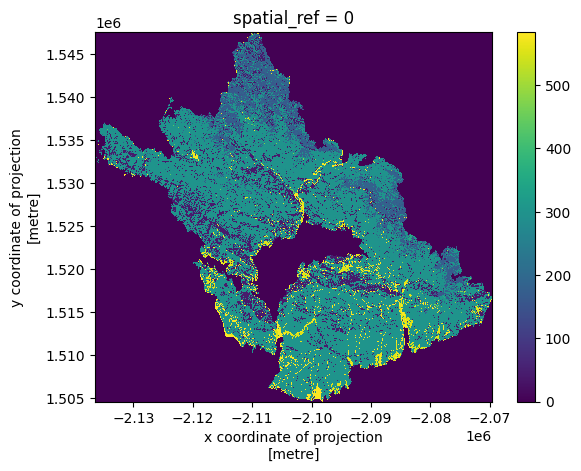

In [21]:
lulc_clip = (lulc.rio.clip_box(*thomas_fire_match.total_bounds)
             .rio.clip(thomas_fire_match.geometry))

lulc_clip.plot()

## Land cover statistics
Calculate land cover statistics within the Thomas Fire perimeter

In [22]:
lulc_clip

<xarray.DataArray (y: 1434, x: 2228)> Size: 6MB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)
Coordinates:
  * x            (x) float64 18kB -2.136e+06 -2.136e+06 ... -2.07e+06 -2.07e+06
  * y            (y) float64 11kB 1.548e+06 1.548e+06 ... 1.505e+06 1.505e+06
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_SOFTWARE:        ERDAS IMAGINE
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    TIFFTAG_RESOLUTIONUNIT:  2 (pixels/inch)
    AREA_OR_POINT:           Area
    scale_factor:            1.0
    add_offset:              0.0
    _FillValue:              0

In [25]:
#  Get the number of pixels per class
values, counts = np.unique(lulc_clip, return_counts= True)

In [26]:
values

array([  0,  39,  40,  41,  42,  43,  45,  55, 159, 162, 165, 183, 277,
       278, 282, 296, 297, 300, 302, 303, 304, 305, 359, 360, 383, 385,
       432, 470, 472, 485, 489, 516, 539, 540, 547, 552, 553, 556, 557,
       558, 567, 568, 578, 579, 581, 582, 583, 584], dtype=uint16)

In [27]:
counts

array([1927870,    6856,     361,  133704,    3638,   23150,    2907,
          4974,    3727,   60203,    5102,   75925,     378,   11098,
            29,      98,   64072,   69700,  183963,  454489,   88504,
           799,     750,     684,      28,      90,     865,     262,
          1329,      54,      44,      27,     298,      24,      15,
            43,       7,   18996,    2181,     485,      13,      20,
            10,    1858,   40653,    3782,     829,      58])

In [34]:
# Create a data frame with the pixels and their counts
d = {'code' : values,
      'counts' : counts }

pix_counts = pd.DataFrame(d)

In [35]:
labels

,class_label,code
0,0,0
1,South Florida Bayhead Swamp,1
2,South Florida Cypress Dome,2
3,South Florida Dwarf Cypress Savanna,3
4,South Florida Mangrove Swamp,4
...,...,...
580,"Quarries, Mines, Gravel Pits and Oil Wells",580
581,"Developed, Open Space",581
582,"Developed, Low Intensity",582
583,"Developed, Medium Intensity",583


In [36]:
pix_counts

,code,counts
0,0,1927870
1,39,6856
2,40,361
3,41,133704
4,42,3638
5,43,23150
6,45,2907
7,55,4974
8,159,3727
9,162,60203


In [ ]:
# Create dataframe that contains the code and the class
classes = pix_counts.merge(labels, how = 'inner', on = 'code')

In [38]:
classes

,code,counts,class_label
0,0,1927870,0
1,39,6856,California Central Valley Mixed Oak Savanna
2,40,361,California Coastal Closed-Cone Conifer Forest ...
3,41,133704,California Coastal Live Oak Woodland and Savanna
4,42,3638,California Lower Montane Blue Oak-Foothill Pin...
5,43,23150,Central and Southern California Mixed Evergree...
6,45,2907,Southern California Oak Woodland and Savanna
7,55,4974,Mediterranean California Mixed Evergreen Forest
8,159,3727,California Montane Jeffrey Pine-(Ponderosa Pin...
9,162,60203,Mediterranean California Dry-Mesic Mixed Conif...


In [ ]:
# Subset for only developed areas
developed = classes[classes['class_label'].str.contains('Developed')]

In [43]:
developed

,code,counts,class_label
44,581,40653,"Developed, Open Space"
45,582,3782,"Developed, Low Intensity"
46,583,829,"Developed, Medium Intensity"
47,584,58,"Developed, High Intensity"


In [ ]:
# Sum the total number of developed pixels
burn_developed = developed['counts'].sum()

In [47]:
burn_developed

45322

In [50]:
# Change the data to km^2 from the meters (Note there are 1000 meters in every km)
km_burn_dev= (burn_developed * (30 * 30)) / 1000
km_burn_dev

40789.8

In [52]:
# Store the total number of pixels within the fire perimeter as a variable total_pixels
total_pixels = classes['counts'].sum()